## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import itertools
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

/home/patel_zeel/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/patel_zeel/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [3]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

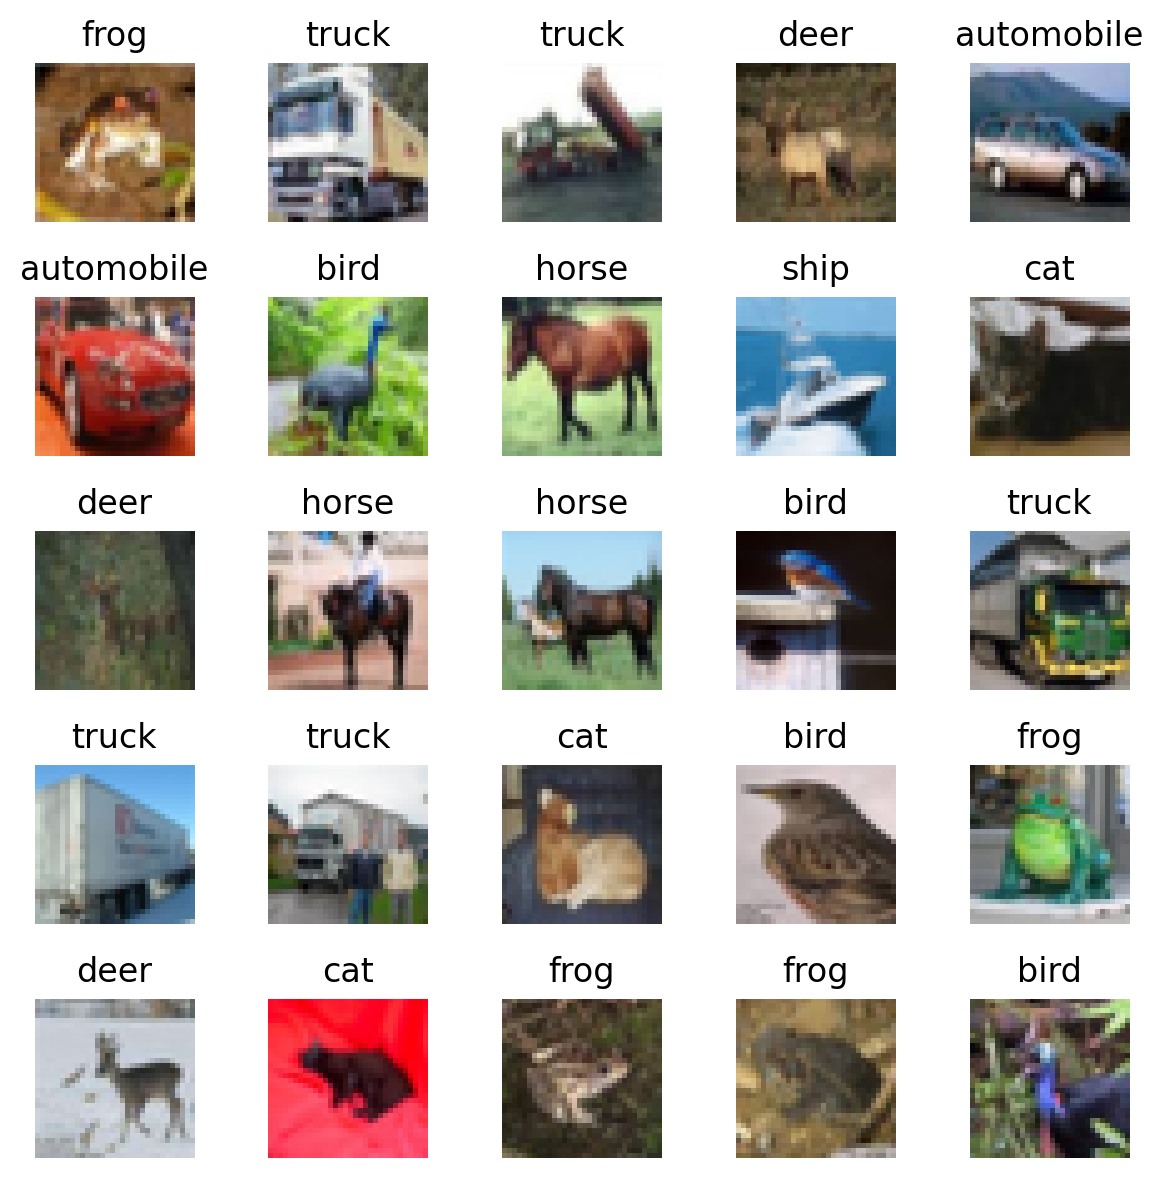

In [4]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

## Train val test split

In [5]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [6]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [7]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

In [8]:
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [9]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

train set accuracy: 7.70%


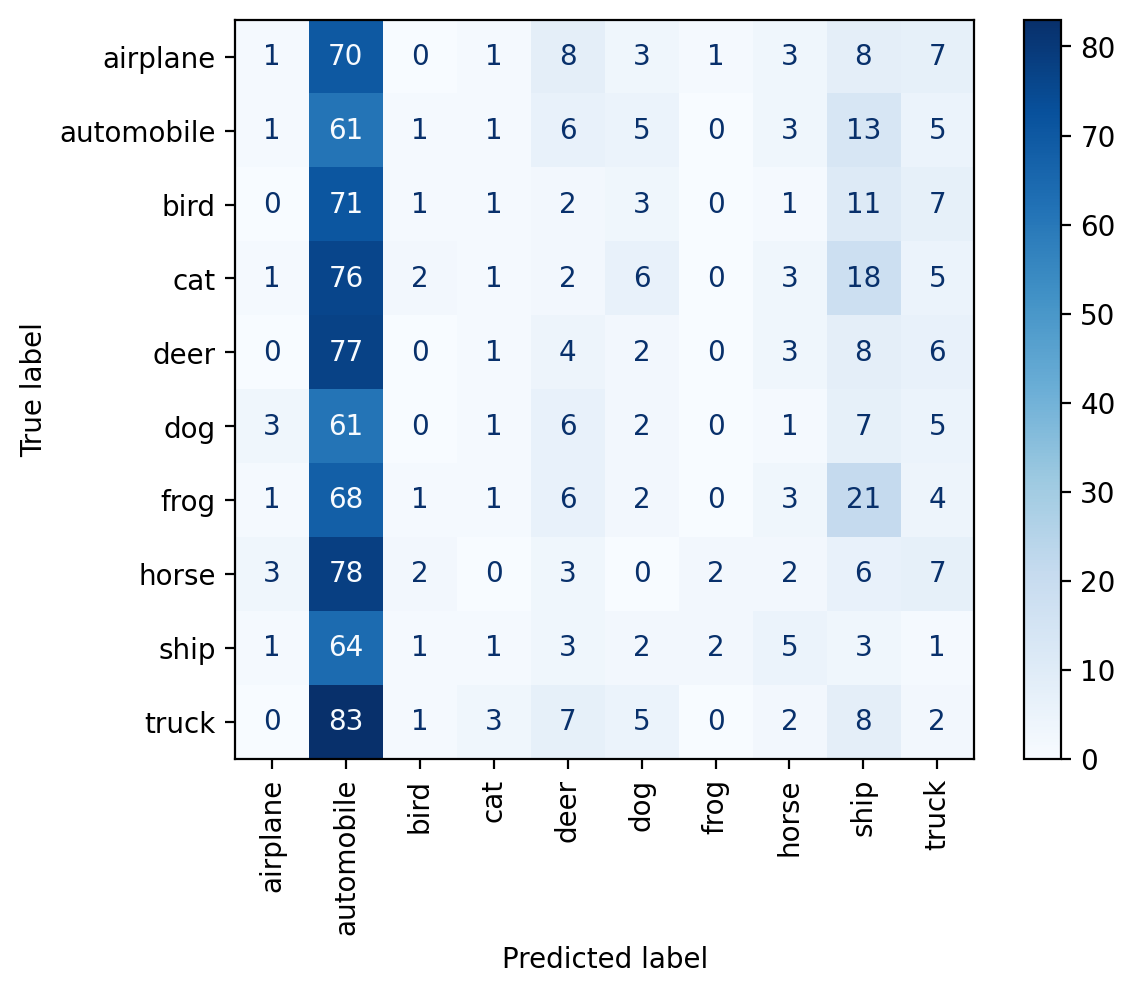

pool set accuracy: 8.36%


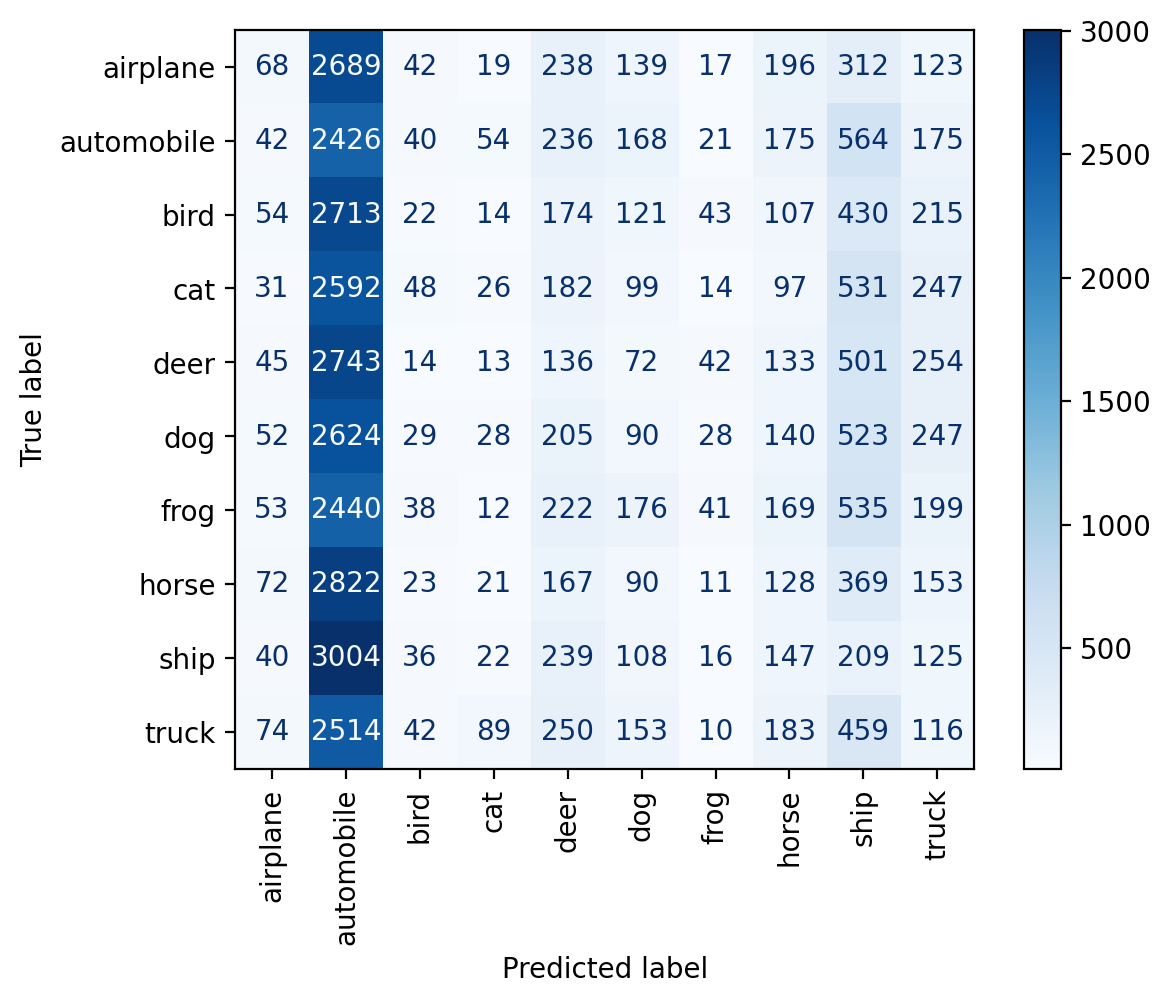

test set accuracy: 8.57%


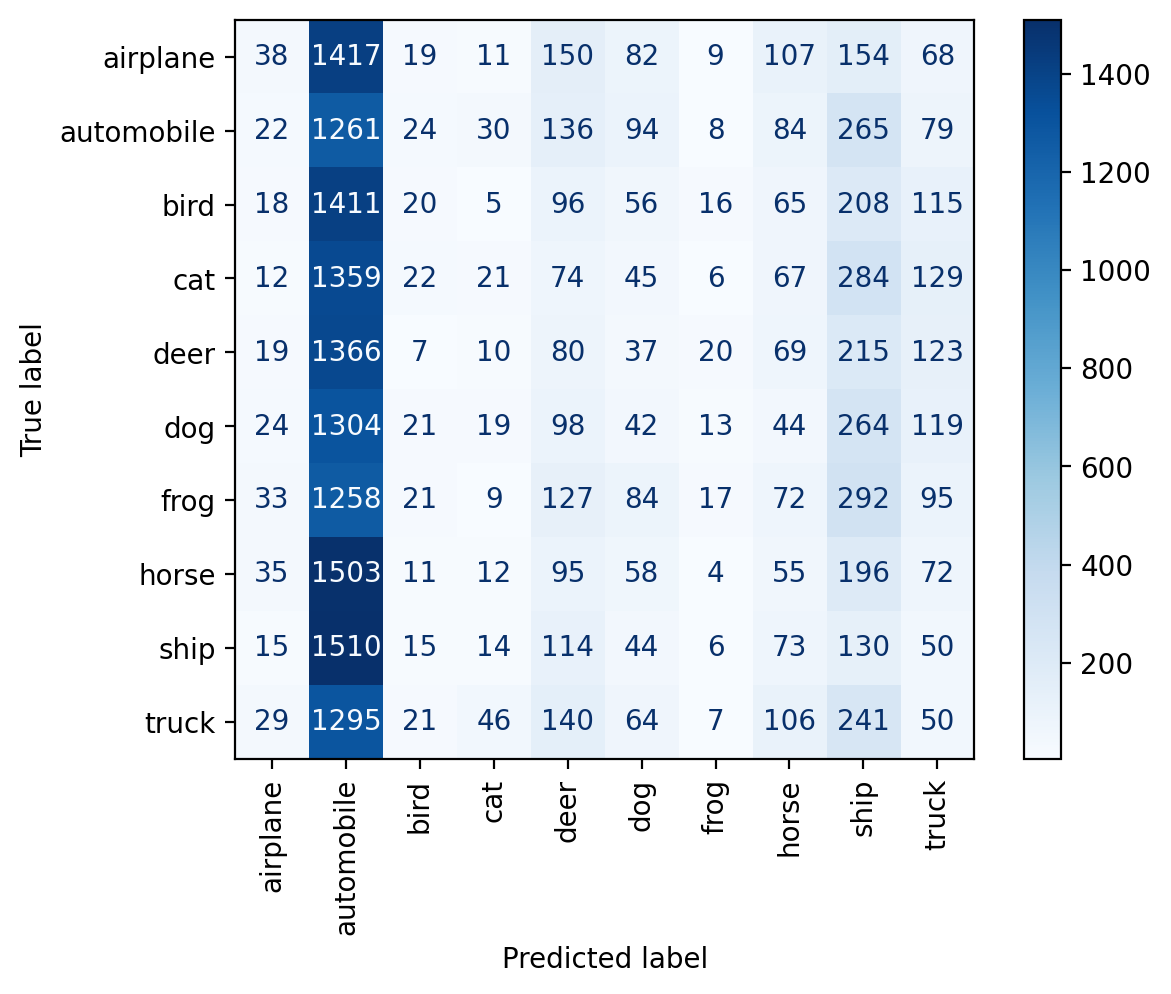

In [10]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()

predict(resnet, dataset.classes, plot_confusion_matrix=True)

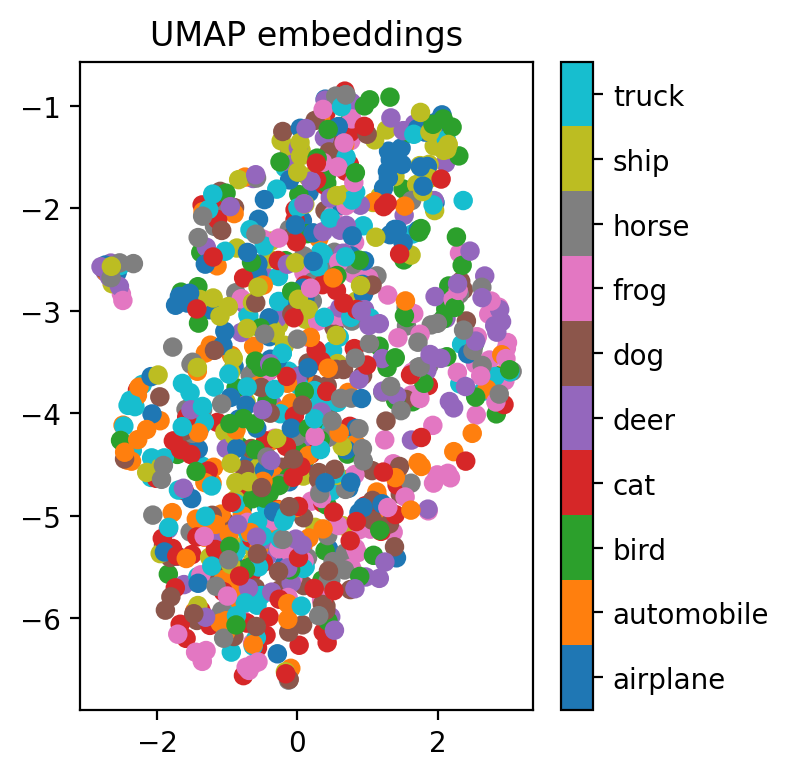

In [11]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

#### Train the model on train set

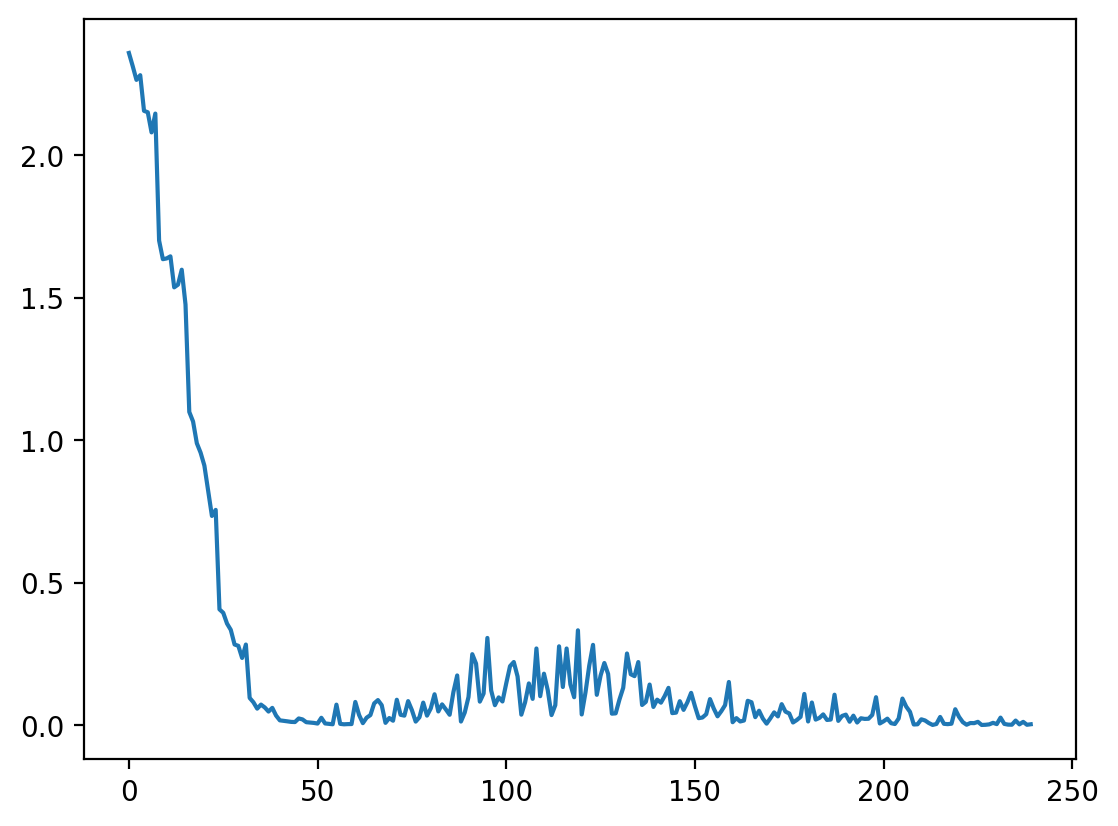

In [12]:
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(resnet, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)
plt.plot(iter_losses)

train set accuracy: 100.00%


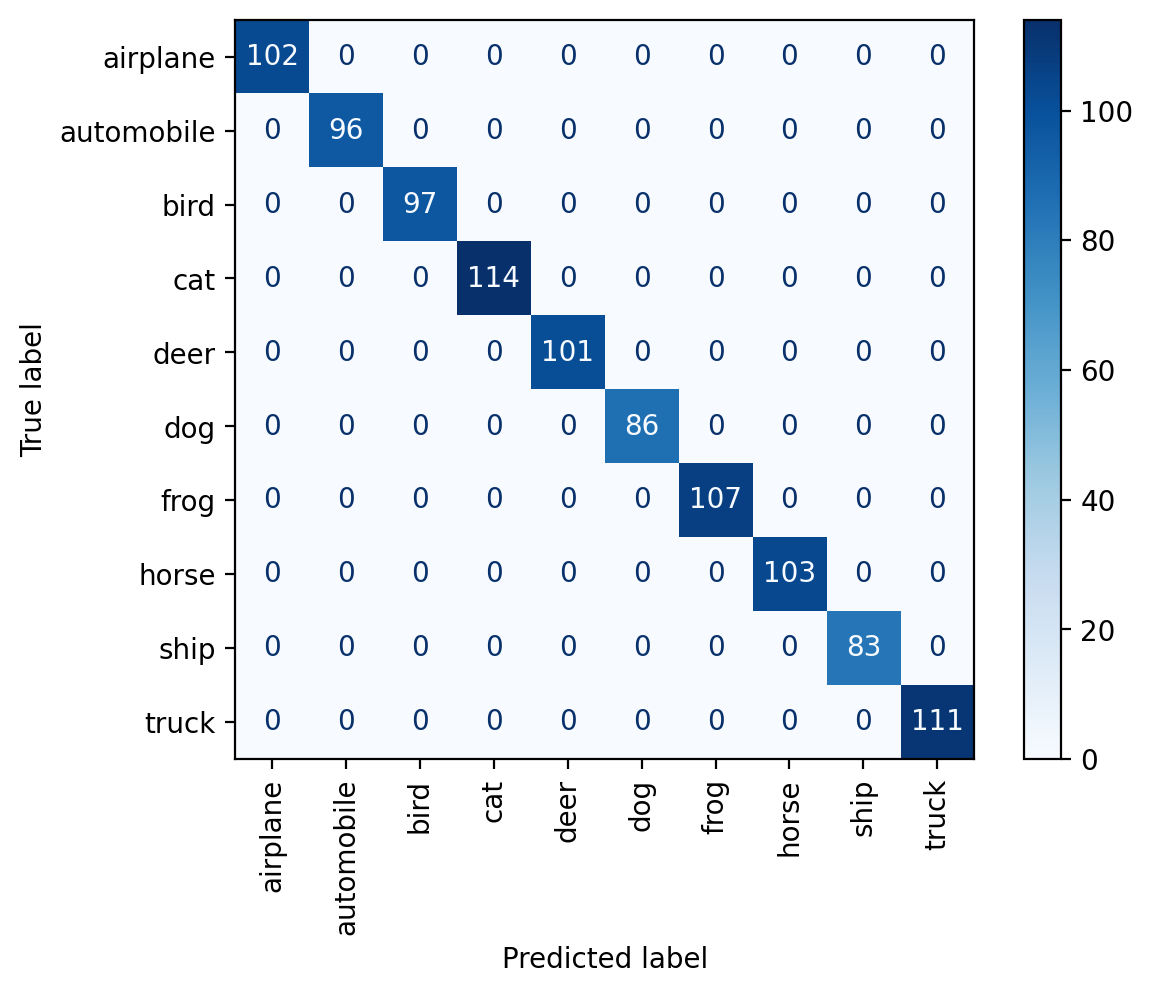

pool set accuracy: 35.30%


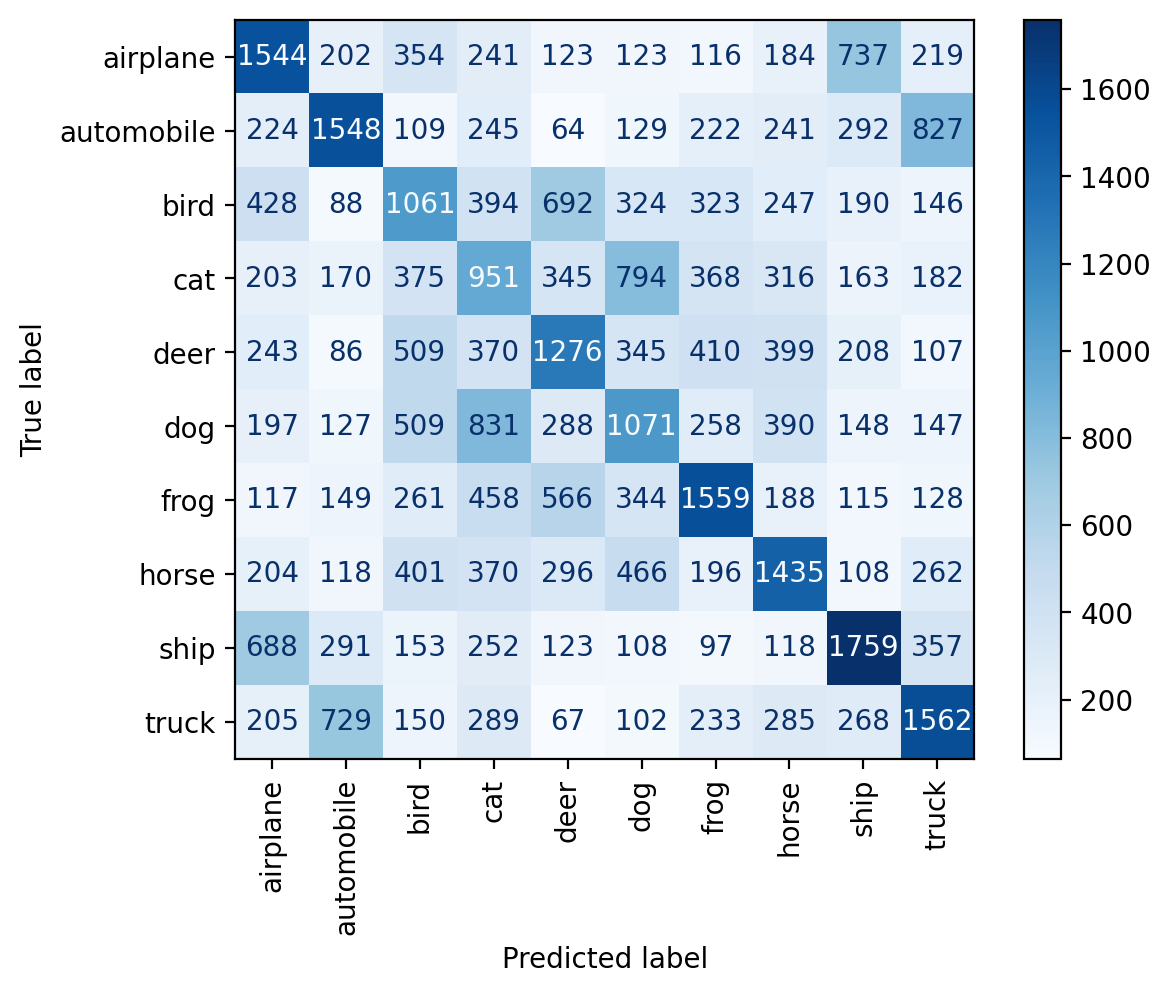

test set accuracy: 34.95%


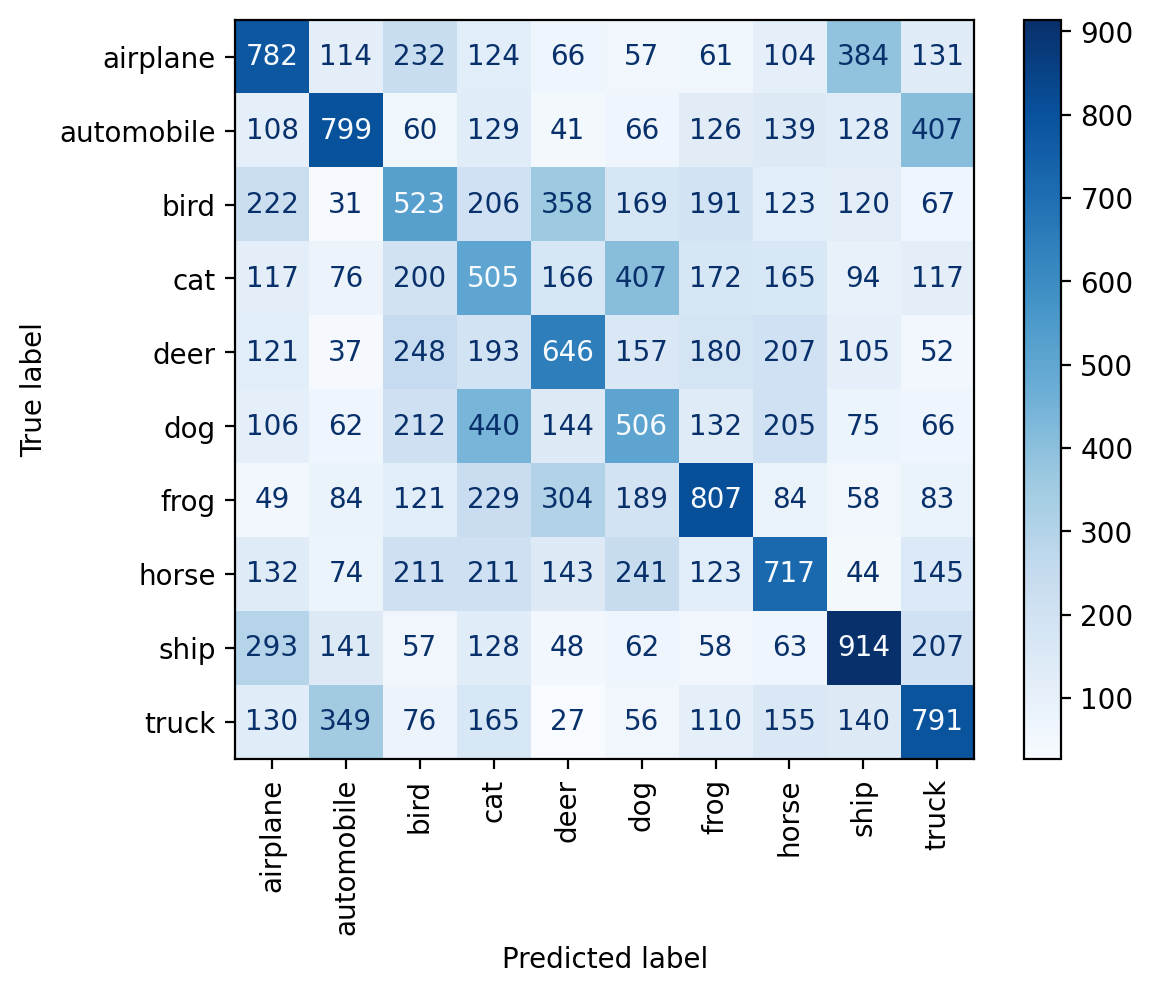

In [13]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


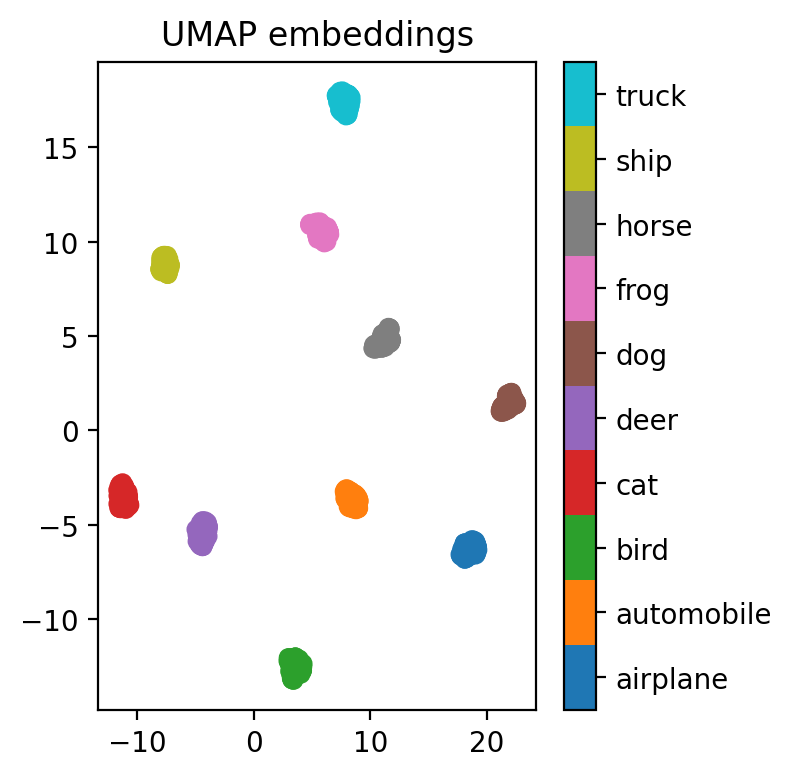

In [14]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

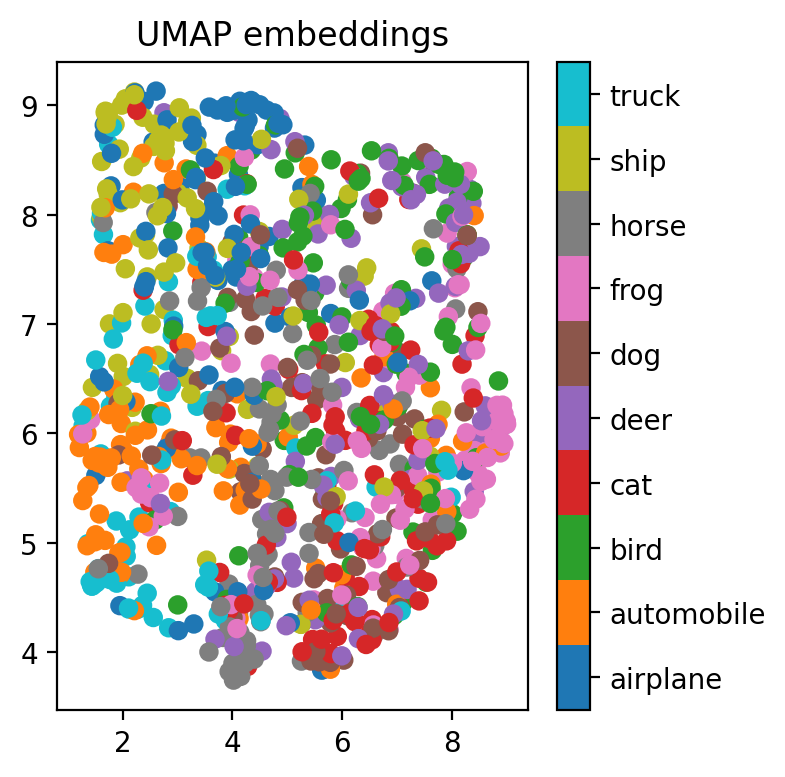

In [15]:
viz_embeddings(resnet, X[pool_idx[:1000]], y[pool_idx[:1000]], device)

Loss: 1.371459: 100%|██████████| 40/40 [00:01<00:00, 32.61it/s]


Epoch 1: 1.63536845703125


Loss: 1.231311: 100%|██████████| 40/40 [00:01<00:00, 35.76it/s]


Epoch 2: 1.215863427734375


Loss: 0.730367: 100%|██████████| 40/40 [00:01<00:00, 36.28it/s]


Epoch 3: 0.9996735214233399


Loss: 0.977865: 100%|██████████| 40/40 [00:01<00:00, 37.27it/s]


Epoch 4: 0.8002303009033203


Loss: 0.810251: 100%|██████████| 40/40 [00:01<00:00, 35.61it/s]


Epoch 5: 0.666905502319336


Loss: 0.567201: 100%|██████████| 40/40 [00:01<00:00, 35.88it/s]


Epoch 6: 0.5030688285827637


Loss: 0.320487: 100%|██████████| 40/40 [00:01<00:00, 34.40it/s]


Epoch 7: 0.3773266990661621


Loss: 0.412983: 100%|██████████| 40/40 [00:01<00:00, 33.86it/s]


Epoch 8: 0.296551838684082


Loss: 0.248653: 100%|██████████| 40/40 [00:01<00:00, 34.59it/s]


Epoch 9: 0.2580745269775391


Loss: 0.191822: 100%|██████████| 40/40 [00:01<00:00, 35.76it/s]


Epoch 10: 0.19489268951416017


Loss: 0.122035: 100%|██████████| 40/40 [00:01<00:00, 36.67it/s]


Epoch 11: 0.15113052501678467


Loss: 0.292454: 100%|██████████| 40/40 [00:01<00:00, 36.83it/s]


Epoch 12: 0.12067589035034179


Loss: 0.204772: 100%|██████████| 40/40 [00:01<00:00, 37.11it/s]


Epoch 13: 0.22909843368530272


Loss: 0.296079: 100%|██████████| 40/40 [00:01<00:00, 37.18it/s]


Epoch 14: 0.11235262069702148


Loss: 0.122087: 100%|██████████| 40/40 [00:01<00:00, 37.03it/s]


Epoch 15: 0.12197829084396362


Loss: 0.093618: 100%|██████████| 40/40 [00:01<00:00, 36.71it/s]


Epoch 16: 0.06675038728713989


Loss: 0.132862: 100%|██████████| 40/40 [00:01<00:00, 36.33it/s]


Epoch 17: 0.09174075212478637


Loss: 0.022098: 100%|██████████| 40/40 [00:01<00:00, 36.95it/s]


Epoch 18: 0.06559248185157776


Loss: 0.023326: 100%|██████████| 40/40 [00:01<00:00, 37.19it/s]


Epoch 19: 0.02701311411857605


Loss: 0.126091: 100%|██████████| 40/40 [00:01<00:00, 36.84it/s]


Epoch 20: 0.023329851984977723


Loss: 0.453509: 100%|██████████| 40/40 [00:01<00:00, 36.01it/s]


Epoch 21: 0.13784839420318604


Loss: 0.181141: 100%|██████████| 40/40 [00:01<00:00, 36.66it/s]


Epoch 22: 0.1694463430404663


Loss: 0.075287: 100%|██████████| 40/40 [00:01<00:00, 36.50it/s]


Epoch 23: 0.06713475942611695


Loss: 0.084234: 100%|██████████| 40/40 [00:01<00:00, 36.48it/s]


Epoch 24: 0.04248725972175598


Loss: 0.122055: 100%|██████████| 40/40 [00:01<00:00, 36.66it/s]


Epoch 25: 0.026764639985561372


Loss: 0.271963: 100%|██████████| 40/40 [00:01<00:00, 36.81it/s]


Epoch 26: 0.0885991590976715


Loss: 0.137583: 100%|██████████| 40/40 [00:01<00:00, 36.58it/s]


Epoch 27: 0.13708527526855468


Loss: 0.048741: 100%|██████████| 40/40 [00:01<00:00, 35.93it/s]


Epoch 28: 0.08999264421463013


Loss: 0.089785: 100%|██████████| 40/40 [00:01<00:00, 36.22it/s]


Epoch 29: 0.03610865006446838


Loss: 0.060445: 100%|██████████| 40/40 [00:01<00:00, 36.48it/s]


Epoch 30: 0.0384268846988678


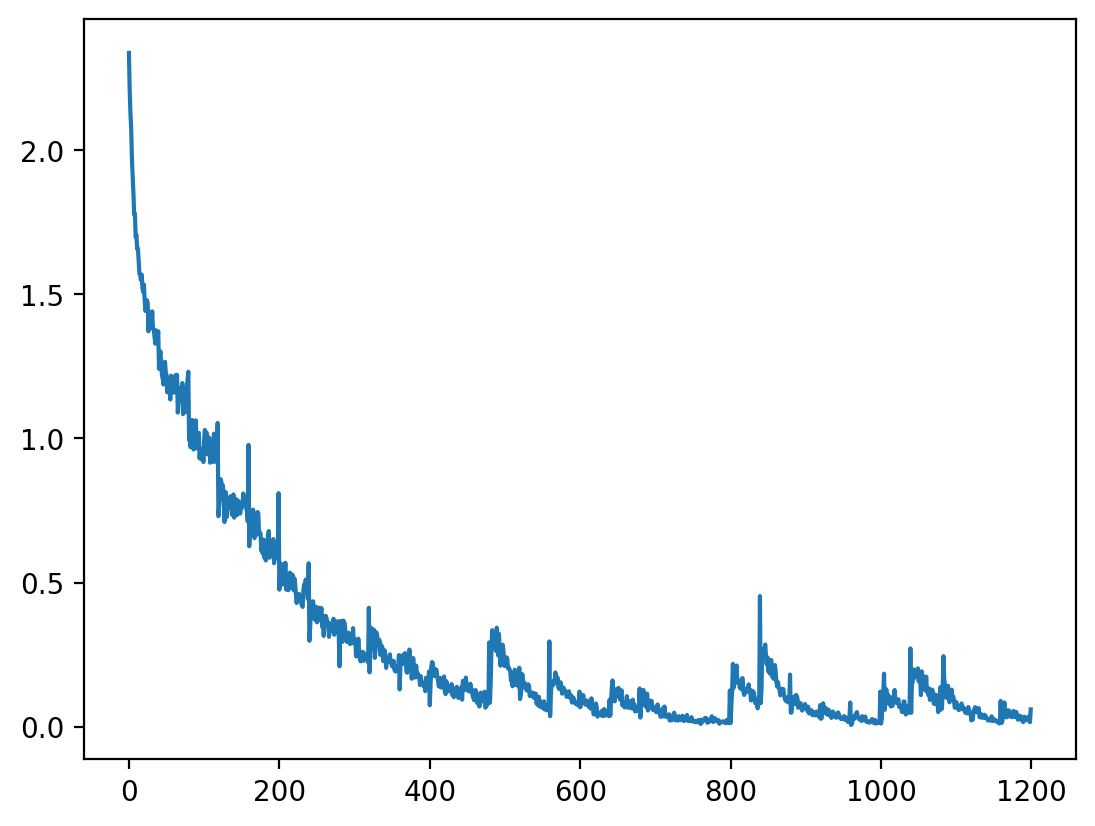

In [16]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)
plt.plot(iter_losses)

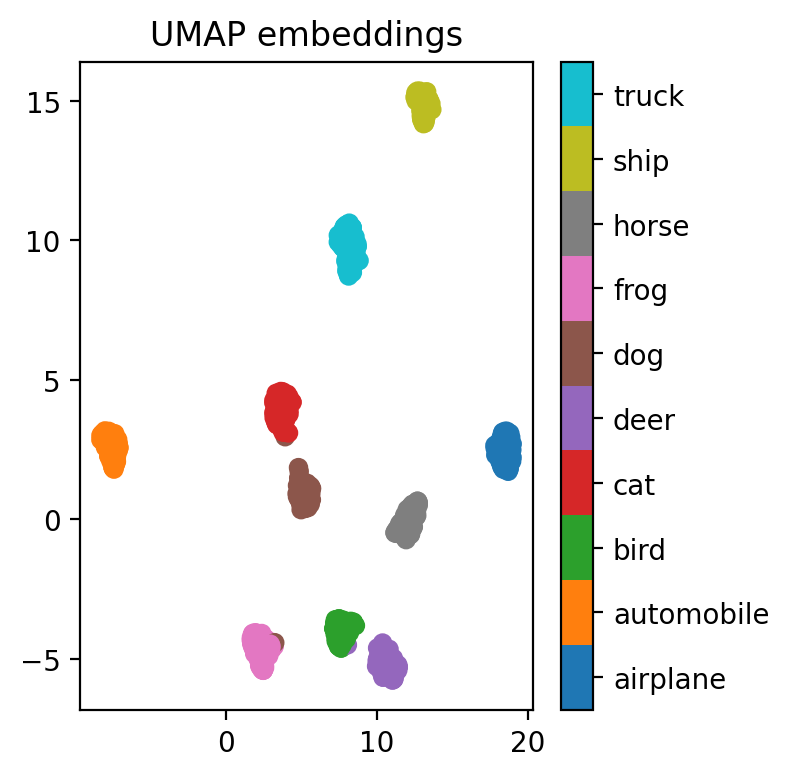

In [17]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

train set accuracy: 99.60%


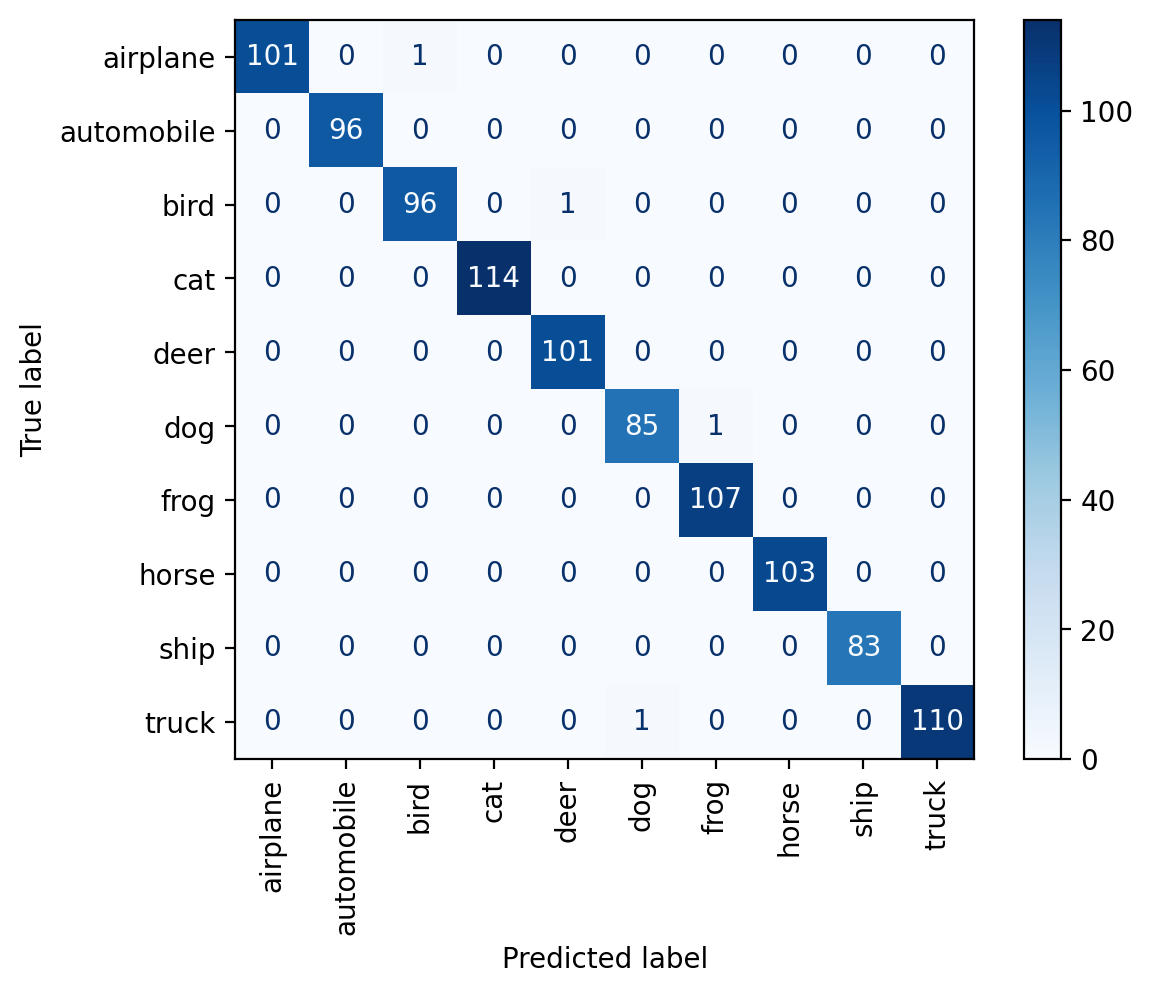

pool set accuracy: 99.74%


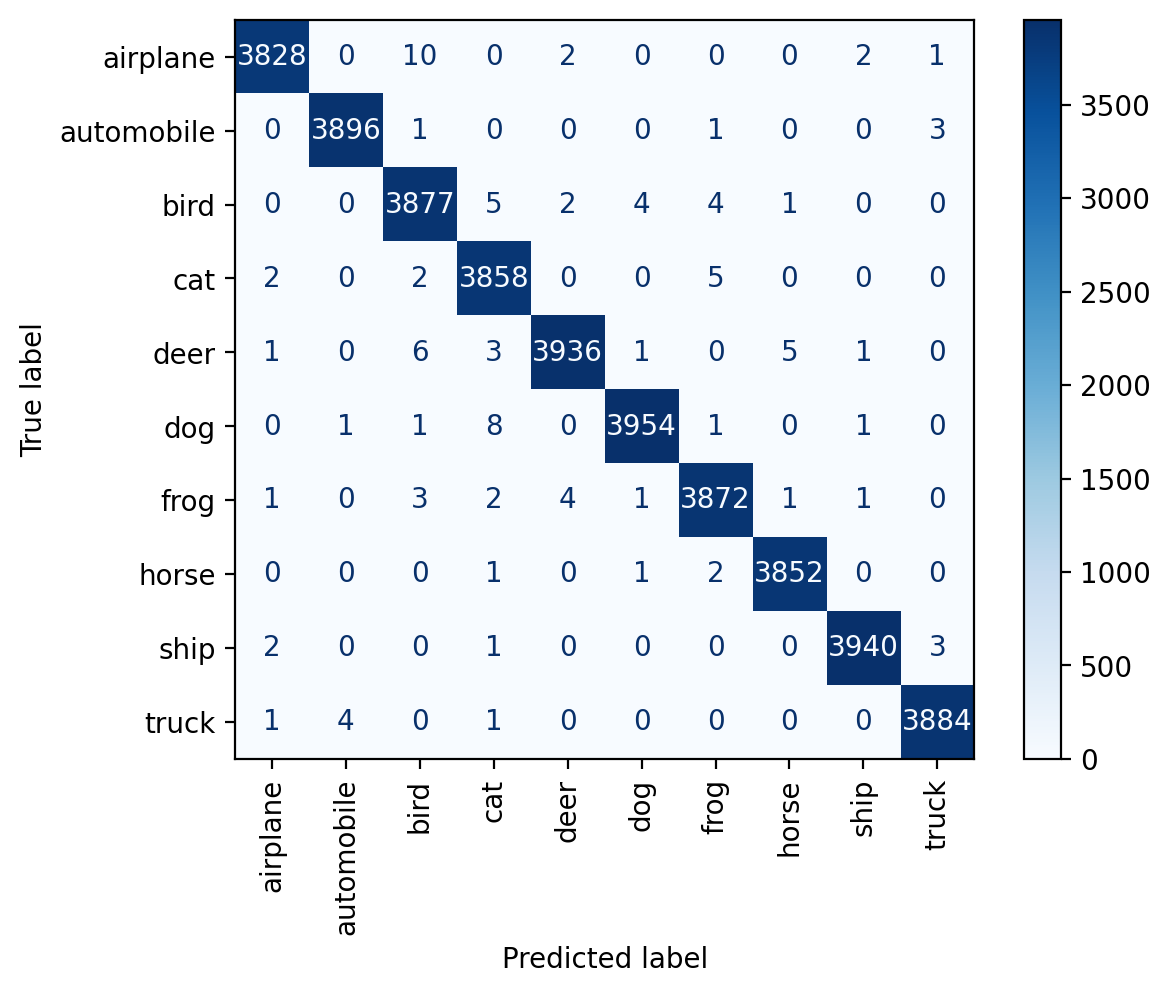

test set accuracy: 62.55%


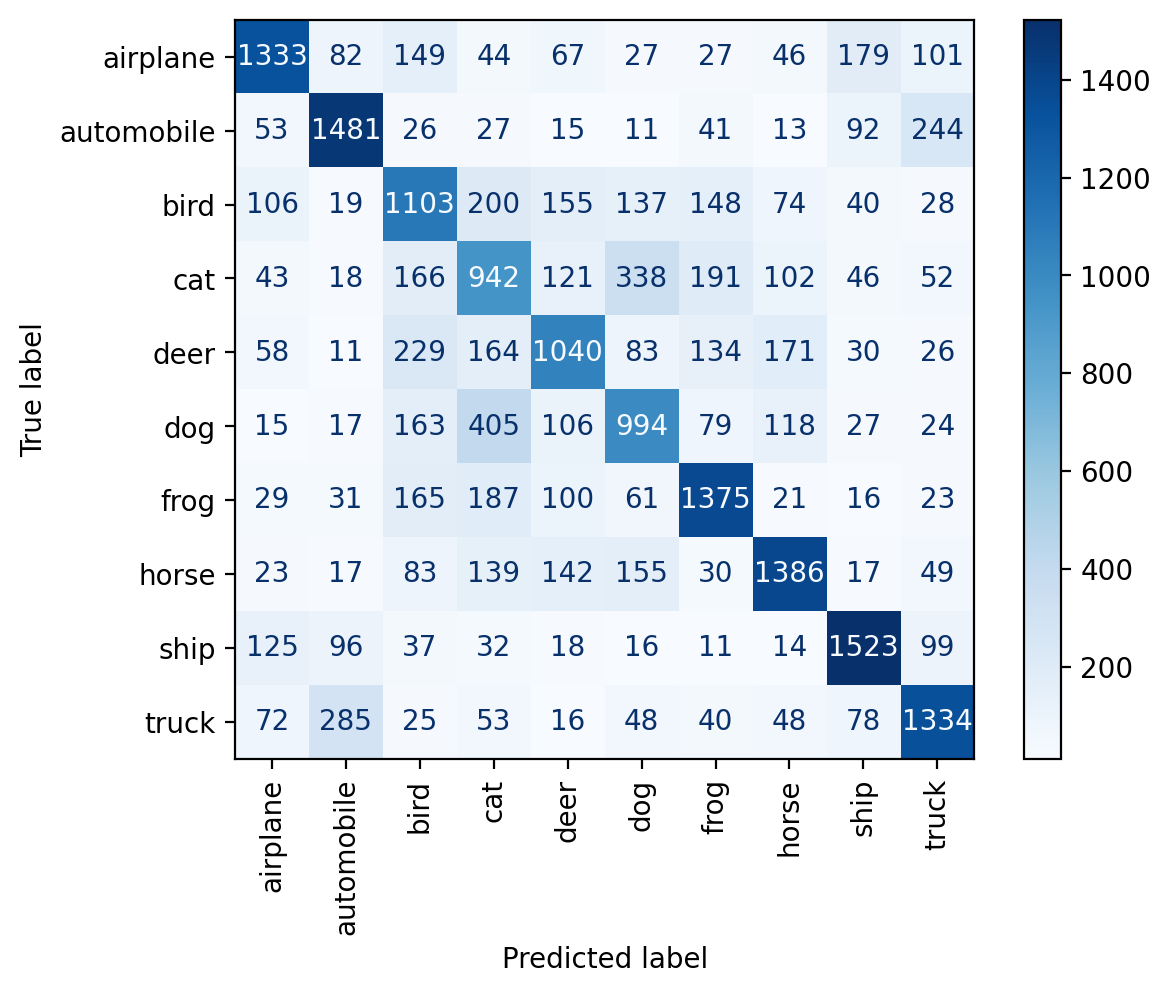

In [18]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

### SSL
#### Task 1: Predict angle of rotation (0, 90, 180, 270) as a classification task

Create a dataset with rotated images and corresponding labels. We can now use a much larger dataset



In [19]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [20]:
X_ssl = []
y_ssl = []

angles_map = {0:0, 90:1, 180:2, 270:3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]]*len(X_rot)))
    
X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

Angle: 0
Angle: 90
Angle: 180
Angle: 270


In [21]:
X_ssl.shape, y_ssl.shape

(torch.Size([160000, 3, 32, 32]), torch.Size([160000]))

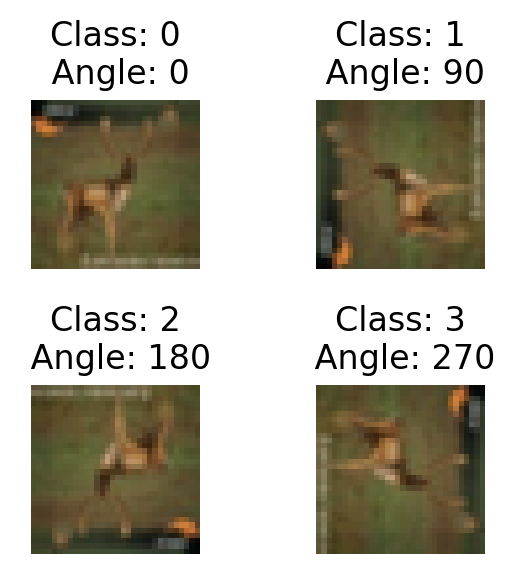

In [22]:
# Plot same image rotated at different angles
def plot_ssl(img_id):
    plt.figure(figsize=(3, 3))
    offset = len(X_train_plus_pool)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(torch.einsum("chw->hwc", X_ssl[offset*i + img_id]))
        plt.axis('off')
        plt.title(f"Class: {angles_map[i*90]}\n Angle: {i*90}")
    plt.tight_layout()
plot_ssl(2)

In [23]:
ssl_angle = ResNetClassifier(models.resnet18, None, n_classes=4, activation=nn.GELU(), dropout=0.1).to(device)

Loss: 0.906877: 100%|██████████| 157/157 [00:04<00:00, 35.74it/s]


Epoch 1: 0.995523120880127


Loss: 0.770616: 100%|██████████| 157/157 [00:04<00:00, 36.46it/s]


Epoch 2: 0.8207647895812988


Loss: 0.687689: 100%|██████████| 157/157 [00:04<00:00, 36.10it/s]


Epoch 3: 0.7223342723846435


Loss: 0.650920: 100%|██████████| 157/157 [00:04<00:00, 36.14it/s]


Epoch 4: 0.6406191101074219


Loss: 0.575362: 100%|██████████| 157/157 [00:04<00:00, 36.25it/s]


Epoch 5: 0.5619581079483033


Loss: 0.595897: 100%|██████████| 157/157 [00:04<00:00, 36.44it/s]


Epoch 6: 0.4840803489685059


Loss: 0.494424: 100%|██████████| 157/157 [00:04<00:00, 36.04it/s]


Epoch 7: 0.40801949653625486


Loss: 0.396756: 100%|██████████| 157/157 [00:04<00:00, 36.48it/s]


Epoch 8: 0.3409143798828125


Loss: 0.313299: 100%|██████████| 157/157 [00:04<00:00, 36.06it/s]


Epoch 9: 0.2733312166213989


Loss: 0.358213: 100%|██████████| 157/157 [00:04<00:00, 36.12it/s]


Epoch 10: 0.22178221559524536


Loss: 0.247673: 100%|██████████| 157/157 [00:04<00:00, 36.25it/s]


Epoch 11: 0.18022032279968261


Loss: 0.154754: 100%|██████████| 157/157 [00:04<00:00, 36.58it/s]


Epoch 12: 0.15229416909217836


Loss: 0.143879: 100%|██████████| 157/157 [00:04<00:00, 35.07it/s]


Epoch 13: 0.12705237154960633


Loss: 0.127578: 100%|██████████| 157/157 [00:04<00:00, 36.04it/s]


Epoch 14: 0.10992165560722351


Loss: 0.144064: 100%|██████████| 157/157 [00:04<00:00, 36.00it/s]


Epoch 15: 0.09413576040267944


Loss: 0.148931: 100%|██████████| 157/157 [00:04<00:00, 36.32it/s]


Epoch 16: 0.08731715087890625


Loss: 0.140250: 100%|██████████| 157/157 [00:04<00:00, 36.30it/s]


Epoch 17: 0.07945195858478546


Loss: 0.068014: 100%|██████████| 157/157 [00:04<00:00, 36.65it/s]


Epoch 18: 0.07207317545413972


Loss: 0.065602: 100%|██████████| 157/157 [00:04<00:00, 36.68it/s]


Epoch 19: 0.06495723311901093


Loss: 0.102576: 100%|██████████| 157/157 [00:04<00:00, 36.63it/s]

Epoch 20: 0.06018465722799301


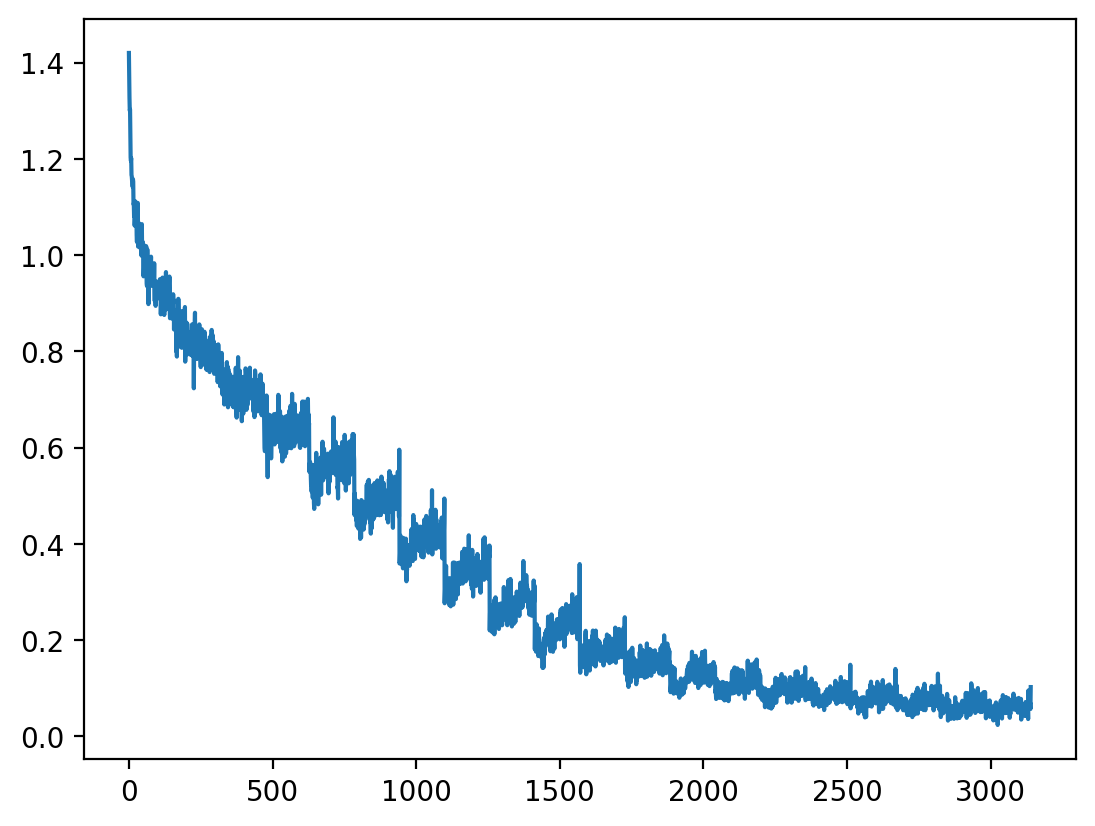

In [24]:
iter_losses, epoch_losses = train_fn(ssl_angle, X_ssl, y_ssl, lr=3e-4, loss_fn=nn.CrossEntropyLoss(),
                                        batch_size=1024, epochs=20)
plt.plot(iter_losses)

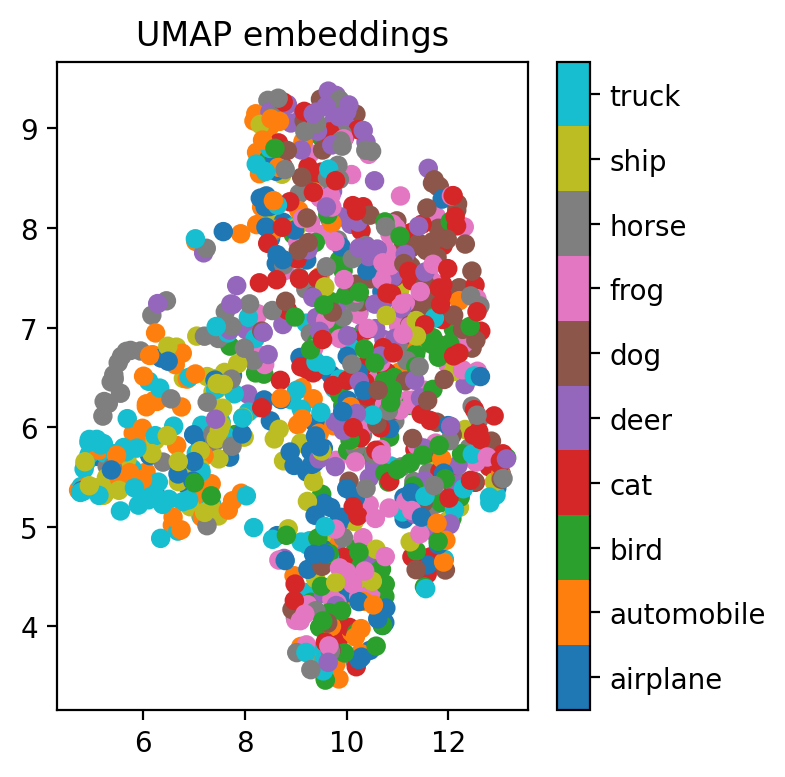

In [25]:
# Visualise the embeddings of the SSL model trained on angles dataset 
# (but wrt original 10 classes)
viz_embeddings(ssl_angle, X[train_idx], y[train_idx], device)

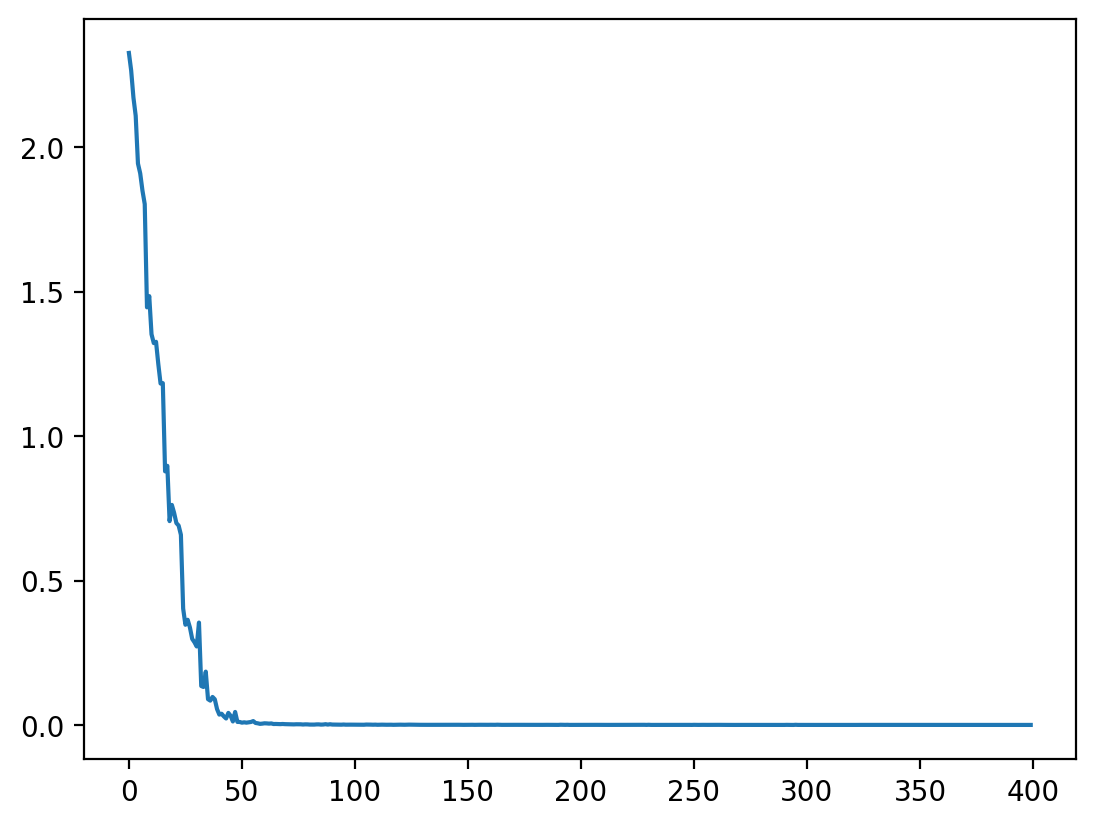

In [26]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())

iter_losses, epoch_losses = train_fn(net_pretrained, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, epochs=50, batch_size=128, verbose=False)
plt.plot(iter_losses)

train set accuracy: 100.00%


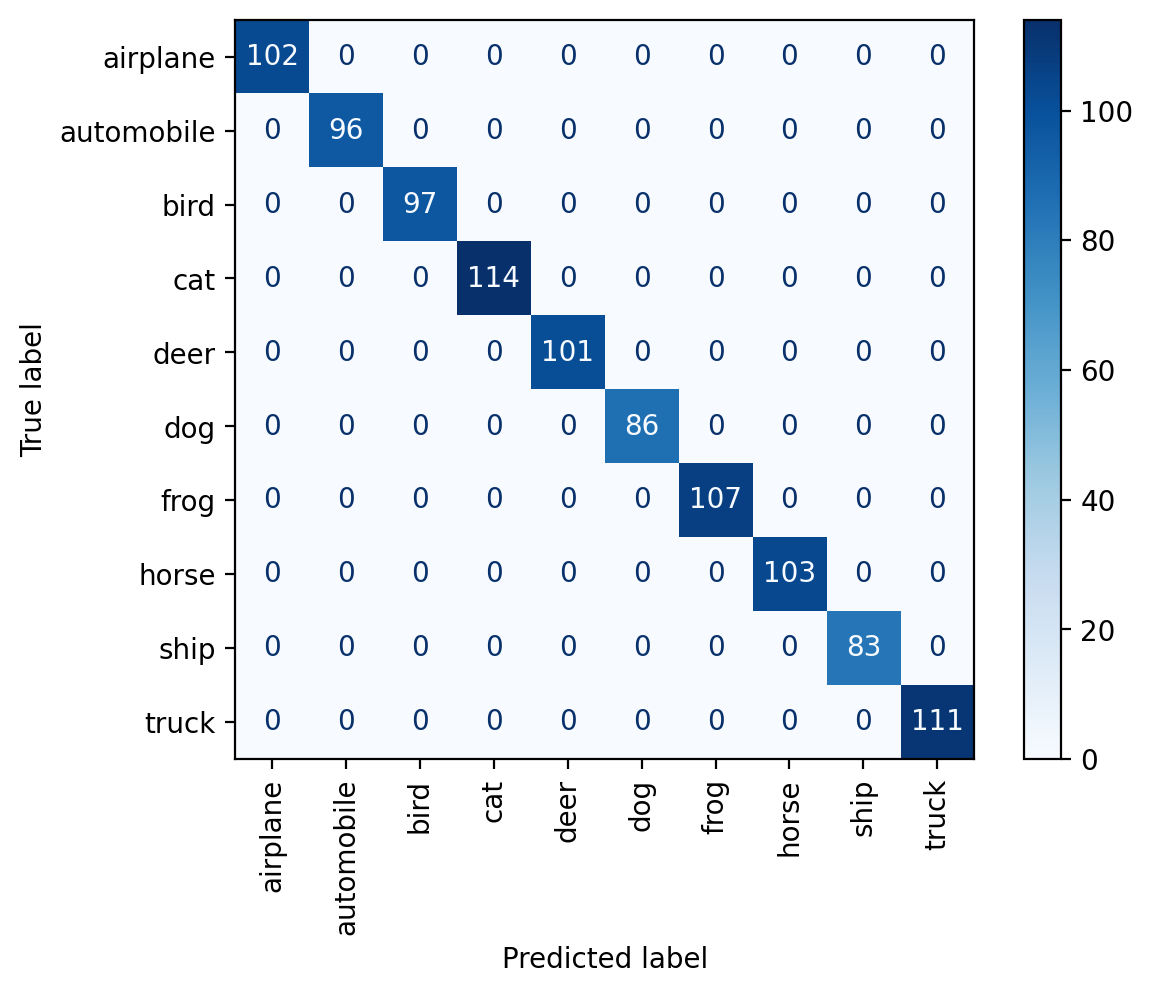

pool set accuracy: 47.21%


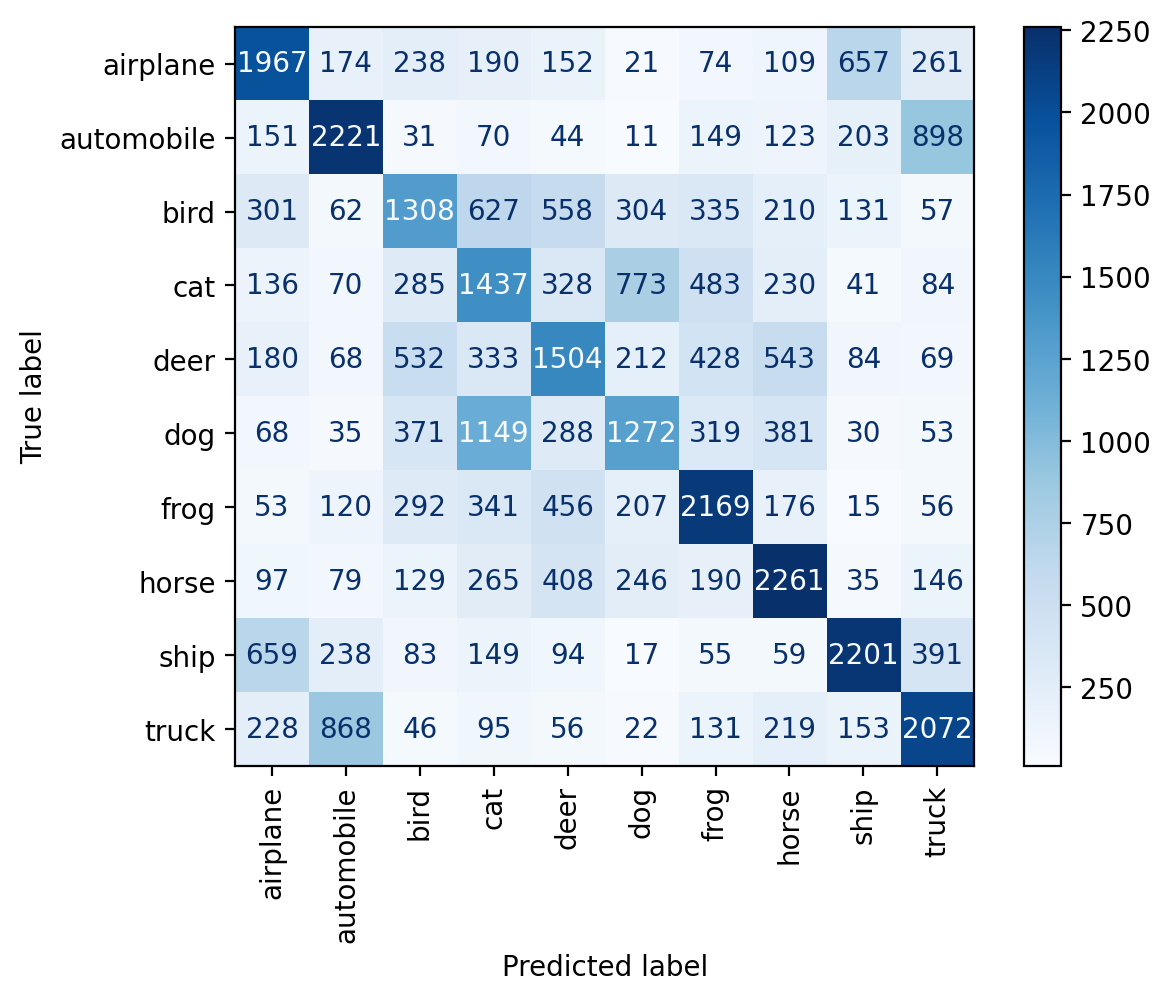

test set accuracy: 46.69%


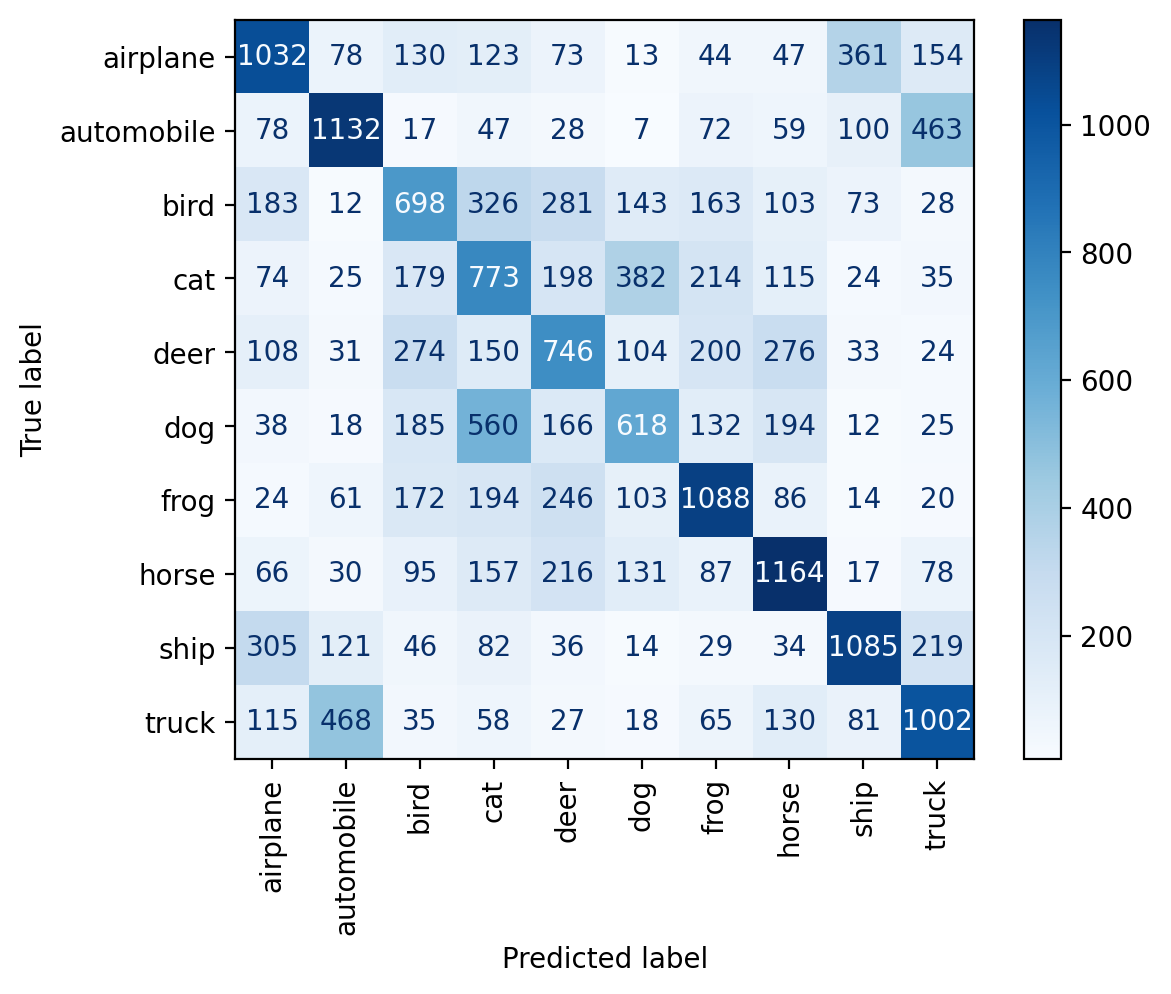

In [27]:
predict(net_pretrained, dataset.classes, plot_confusion_matrix=True)

## Another SSL: Permuation

In [35]:
def get_randperm(img):
    img_0 = img[np.newaxis, :, :16, :16]
    img_1 = img[np.newaxis, :, :16, 16:]
    img_2 = img[np.newaxis, :, 16:, :16]
    img_3 = img[np.newaxis, :, 16:, 16:]
    img_list = torch.cat([img_0, img_1, img_2, img_3], dim=0)
    order = torch.randperm(4)
    
    top = torch.cat([img_list[order[0:1]], img_list[order[1:2]]], dim=2)
    print(top.shape)
    bottom = torch.cat([img_list[order[2:3]], img_list[order[3:4]]], dim=2)
    print(bottom.shape)
    img = torch.cat([top, bottom], dim=-1)
    return img[0], order

images, rotations = torch.vmap(get_randperm, randomness="different")(X[train_plus_pool_idx])
images2, rotations2 = torch.vmap(get_randperm, randomness="different")(X[train_plus_pool_idx])

images = torch.cat([images, images2], dim=0)
rotations = torch.cat([rotations, rotations2], dim=0)

print(images.shape, rotations.shape)

torch.Size([1, 3, 32, 16])
torch.Size([1, 3, 32, 16])
torch.Size([1, 3, 32, 16])
torch.Size([1, 3, 32, 16])
torch.Size([80000, 3, 32, 32]) torch.Size([80000, 4])


In [36]:
rot_list = [''.join(map(str, r.tolist())) for r in rotations]
labels = pd.factorize(rot_list)[0]
labels = torch.tensor(labels).long()
print(labels.shape)

torch.Size([80000])


/tmp/ipykernel_2767529/210267328.py:2: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.factorize(rot_list)[0]


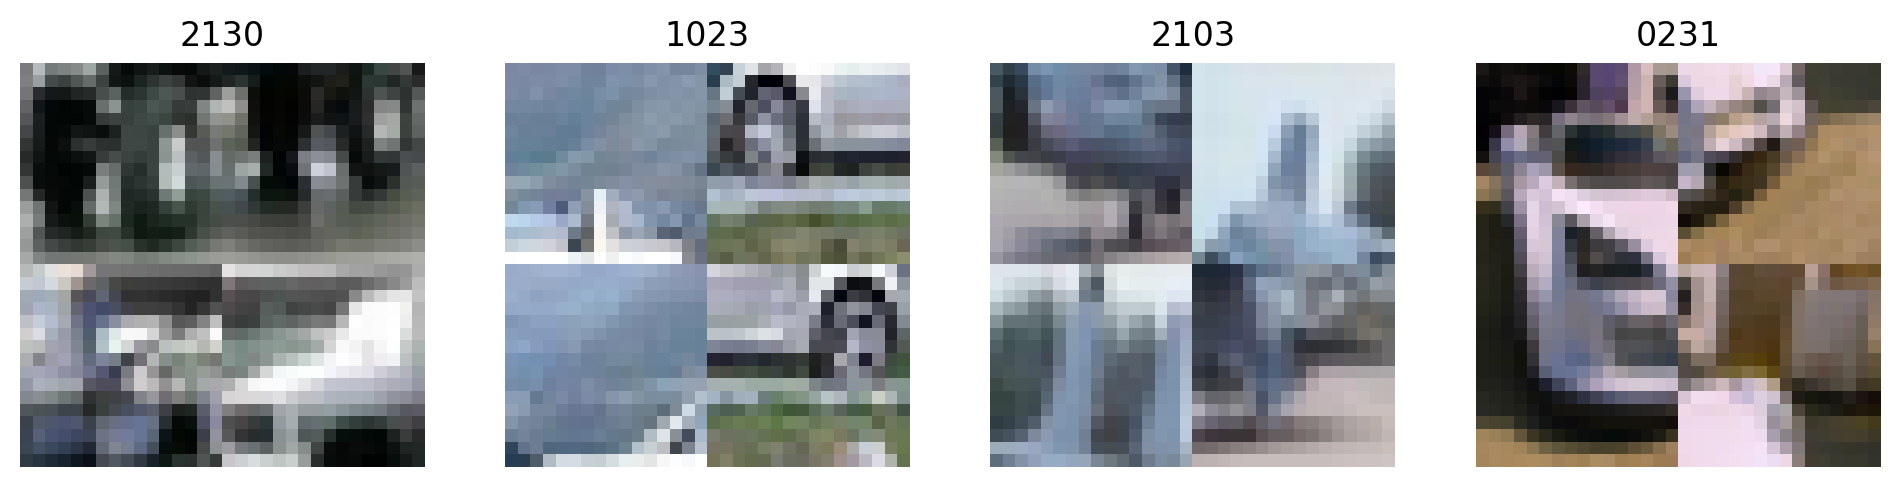

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
offset = 20
for i in range(4):
    ax[i].imshow(torch.einsum("chw->hwc", images[offset+i]))
    ax[i].axis('off')
    ax[i].set_title(rot_list[offset+i])

24


Loss: 1.357030: 100%|██████████| 79/79 [00:02<00:00, 35.62it/s]


Epoch 1: 2.1365387481689453


Loss: 0.804846: 100%|██████████| 79/79 [00:02<00:00, 36.15it/s]


Epoch 2: 1.036408987426758


Loss: 0.597392: 100%|██████████| 79/79 [00:02<00:00, 36.25it/s]


Epoch 3: 0.6859112144470215


Loss: 0.513396: 100%|██████████| 79/79 [00:02<00:00, 36.83it/s]


Epoch 4: 0.47944041595458986


Loss: 0.347402: 100%|██████████| 79/79 [00:02<00:00, 36.43it/s]


Epoch 5: 0.3356689636230469


Loss: 0.379281: 100%|██████████| 79/79 [00:02<00:00, 35.82it/s]


Epoch 6: 0.23661128520965577


Loss: 0.148637: 100%|██████████| 79/79 [00:02<00:00, 36.08it/s]


Epoch 7: 0.1819293487548828


Loss: 0.061559: 100%|██████████| 79/79 [00:02<00:00, 36.46it/s]


Epoch 8: 0.12370609364509583


Loss: 0.099183: 100%|██████████| 79/79 [00:02<00:00, 36.79it/s]


Epoch 9: 0.08431413230895995


Loss: 0.192330: 100%|██████████| 79/79 [00:02<00:00, 36.65it/s]


Epoch 10: 0.07368581428527832


Loss: 0.162460: 100%|██████████| 79/79 [00:02<00:00, 37.14it/s]


Epoch 11: 0.09565490446090698


Loss: 0.083342: 100%|██████████| 79/79 [00:02<00:00, 37.08it/s]


Epoch 12: 0.07360060443878173


Loss: 0.085415: 100%|██████████| 79/79 [00:02<00:00, 37.21it/s]


Epoch 13: 0.058222322964668276


Loss: 0.092794: 100%|██████████| 79/79 [00:02<00:00, 36.97it/s]


Epoch 14: 0.06333429169654846


Loss: 0.060307: 100%|██████████| 79/79 [00:02<00:00, 36.60it/s]


Epoch 15: 0.05648453650474548


Loss: 0.039731: 100%|██████████| 79/79 [00:02<00:00, 36.97it/s]


Epoch 16: 0.047282902812957765


Loss: 0.022570: 100%|██████████| 79/79 [00:02<00:00, 36.79it/s]


Epoch 17: 0.03749733327627182


Loss: 0.037269: 100%|██████████| 79/79 [00:02<00:00, 36.61it/s]


Epoch 18: 0.02615164805650711


Loss: 0.067625: 100%|██████████| 79/79 [00:02<00:00, 36.37it/s]


Epoch 19: 0.02761591753959656


Loss: 0.039099: 100%|██████████| 79/79 [00:02<00:00, 36.58it/s]


Epoch 20: 0.047057318925857544


Loss: 0.033515: 100%|██████████| 79/79 [00:02<00:00, 36.16it/s]


Epoch 21: 0.03995669722557068


Loss: 0.016653: 100%|██████████| 79/79 [00:02<00:00, 35.65it/s]


Epoch 22: 0.03294613227844238


Loss: 0.011956: 100%|██████████| 79/79 [00:02<00:00, 36.13it/s]


Epoch 23: 0.024639331710338594


Loss: 0.019505: 100%|██████████| 79/79 [00:02<00:00, 36.26it/s]


Epoch 24: 0.023566722071170807


Loss: 0.010050: 100%|██████████| 79/79 [00:02<00:00, 36.97it/s]


Epoch 25: 0.024327825087308883


Loss: 0.085263: 100%|██████████| 79/79 [00:02<00:00, 36.67it/s]


Epoch 26: 0.02810042362213135


Loss: 0.041031: 100%|██████████| 79/79 [00:02<00:00, 36.87it/s]


Epoch 27: 0.06495262268781662


Loss: 0.071789: 100%|██████████| 79/79 [00:02<00:00, 36.02it/s]


Epoch 28: 0.038600968408584596


Loss: 0.034459: 100%|██████████| 79/79 [00:02<00:00, 35.65it/s]


Epoch 29: 0.04690443072319031


Loss: 0.026130: 100%|██████████| 79/79 [00:02<00:00, 36.15it/s]


Epoch 30: 0.025199157077074052


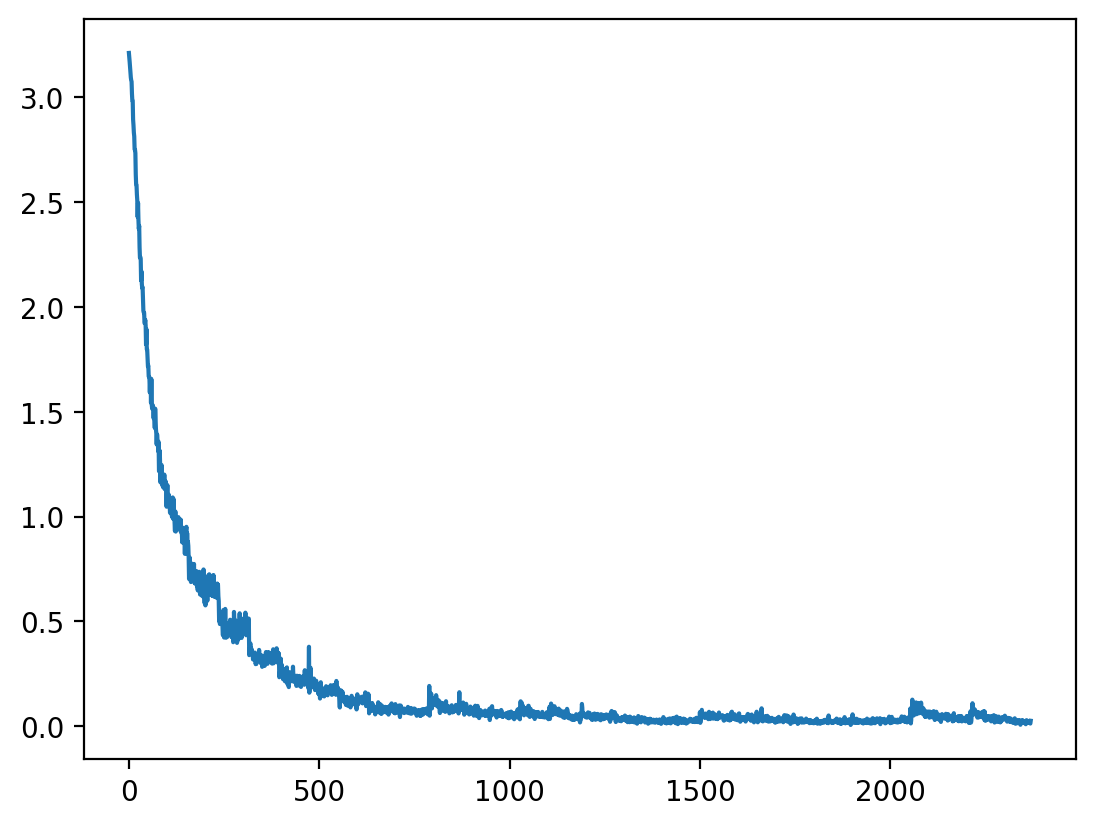

In [43]:
perm_ssl_model = ResNetClassifier(models.resnet18, None, n_classes=24, activation=nn.GELU(), dropout=0.1).to(device)

print(len(set(labels.tolist())))
iter_losses, epoch_losses = train_fn(perm_ssl_model, images, labels, lr=3e-4, loss_fn=nn.CrossEntropyLoss(),
                                        batch_size=1024, epochs=30)
plt.plot(iter_losses)

In [44]:
perm_ssl_model.accuracy(images, labels, batch_size=1024)

100%|██████████| 79/79 [00:00<00:00, 106.22it/s]


0.9924999475479126

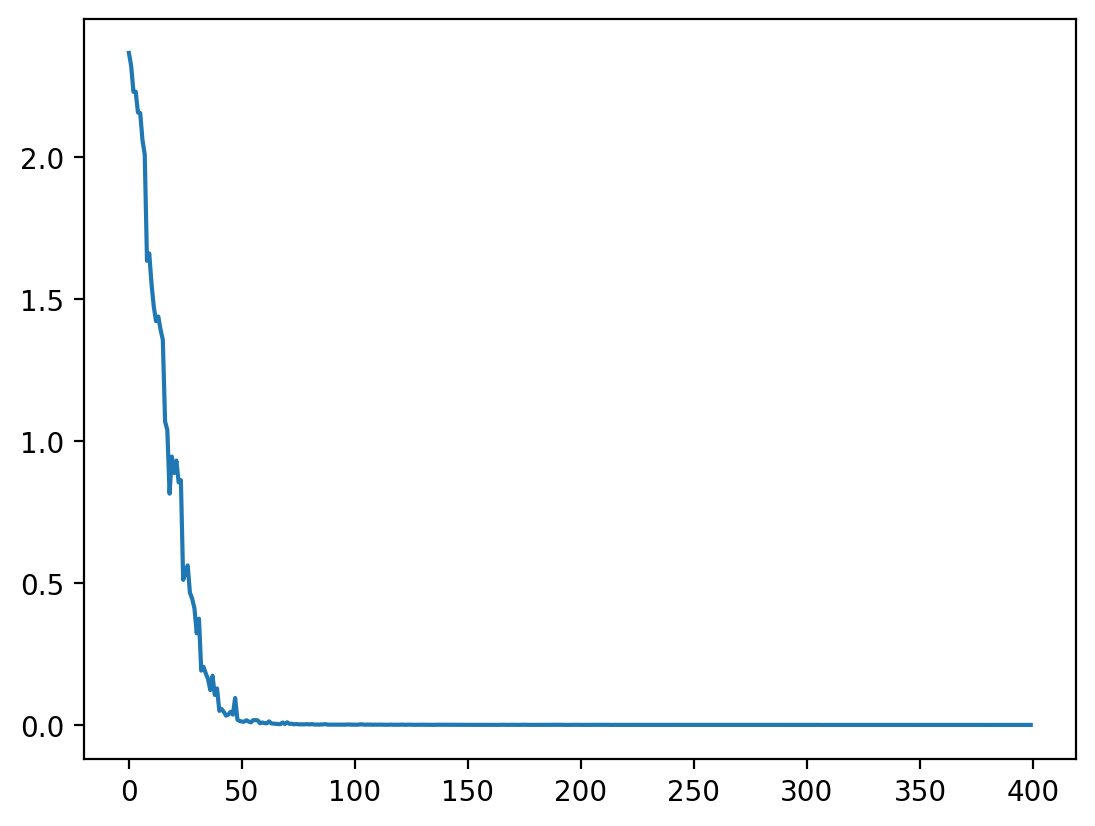

In [45]:
# Now, we can use the features from this model to train the classifier on the original data

net_pretrained = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
net_pretrained.featurizer.load_state_dict(perm_ssl_model.featurizer.state_dict())

iter_losses, epoch_losses = train_fn(net_pretrained, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, epochs=50, batch_size=128, verbose=False)
plt.plot(iter_losses)

train set accuracy: 100.00%


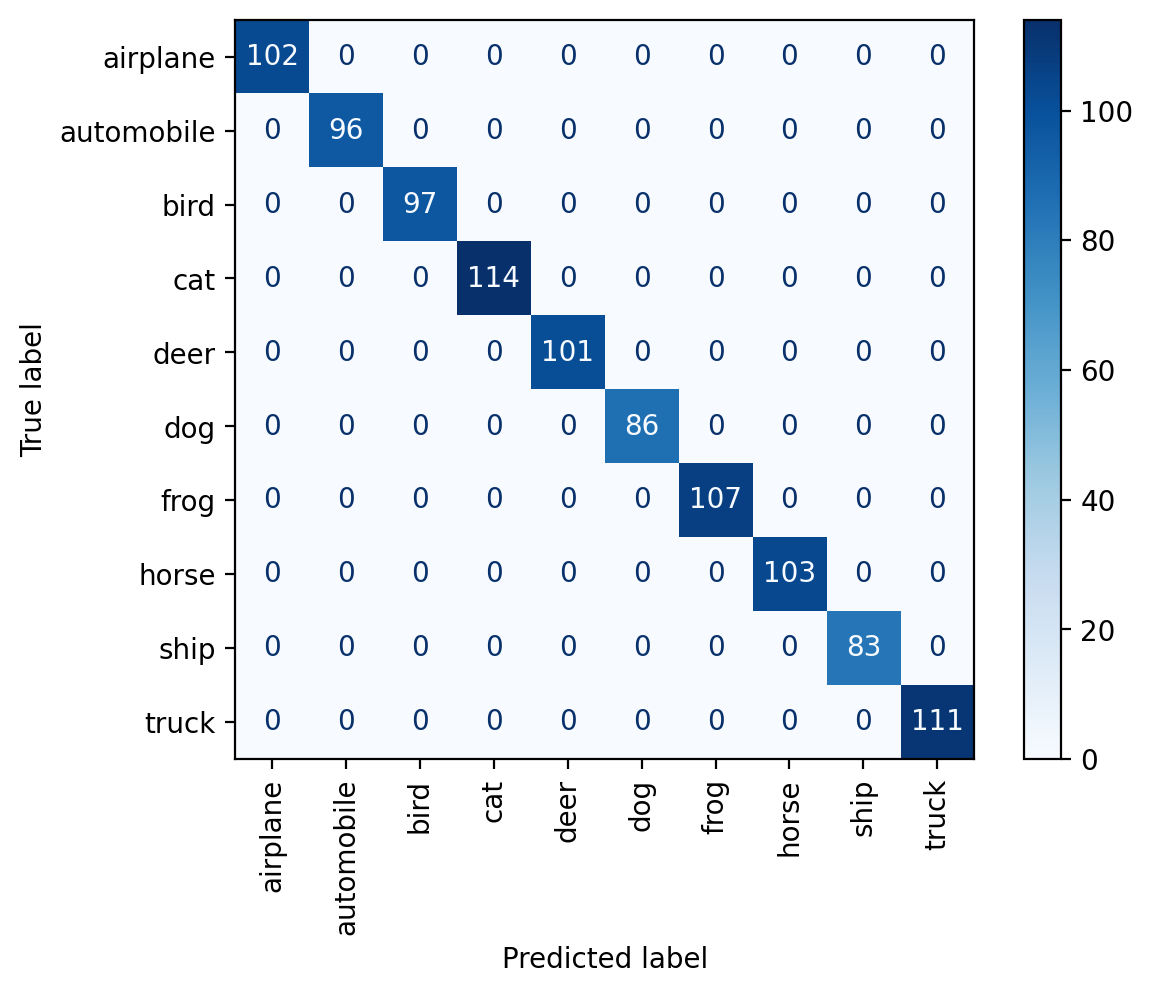

pool set accuracy: 41.09%


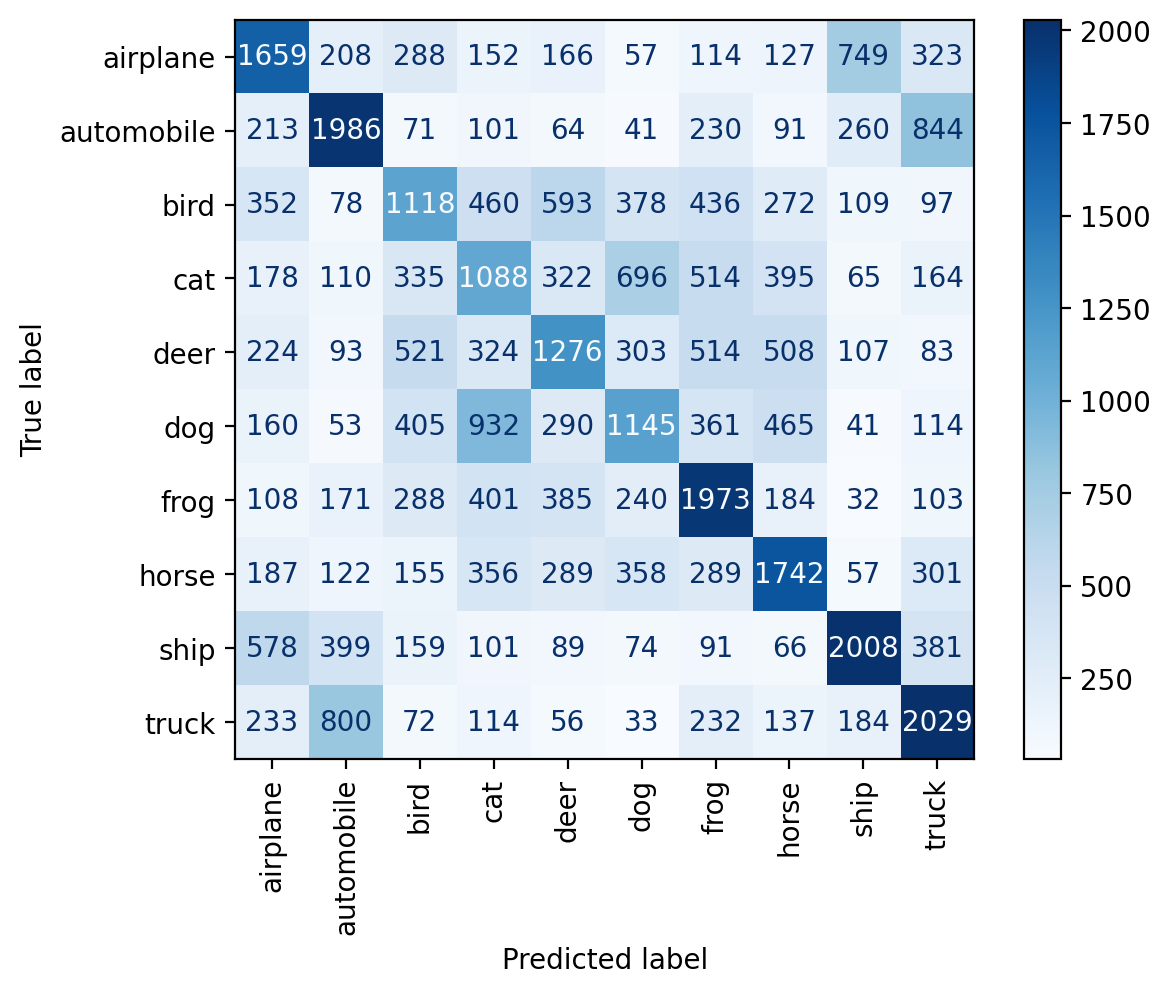

test set accuracy: 40.94%


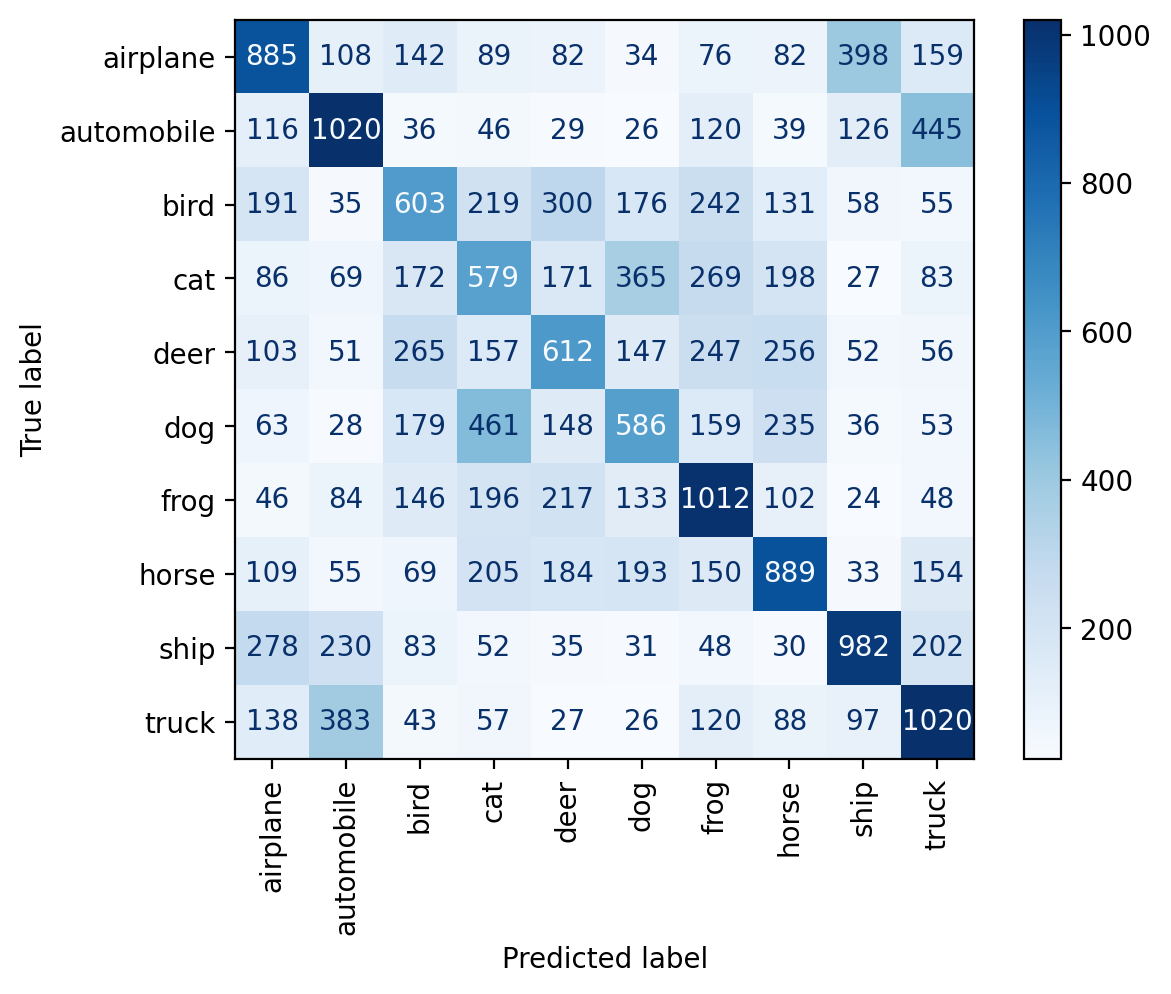

In [46]:
predict(net_pretrained, dataset.classes, plot_confusion_matrix=True)